In [1]:
import os
import csv
import numpy as np
import random
import torch
import torch.nn as nn
from torchmetrics.classification import BinaryAccuracy
import matplotlib.pyplot as plt 
import argparse
from training.train_selective_ssm import train_ssm_block
from training.load_datasets import get_imdb, create_majority_dataset
from models.selective_ssm import SSMBlock, SentimentModel

In [2]:
# # Experiment parameters for the paper:
# devID = 0
# experiment = "length_independence"
# dataset = "majority"
# if dataset == "imdb":
#     T_values = range(100,2001,100)      # Sequence lengths
#     s_A_values = [0.0]                  # Stability margins
#     N = 4                               # Number of states per channel
#     d = 16                              # Number of channels
#     m = 25000                           # Number of samples
#     m_test = 25000                      # Number of test samples
#     ep = 30                             # Number of epochs
#     bs = 256                            # Batch size
#     lr = 1e-2                           # Learning rate
#     wd = 1e-5                           # Weight decay
#     delta = True                        # Use input dependent delta
#     seed = 0                            # Random seed
# elif dataset == "majority":
#     T_values = range(25,401,25)         # Sequence lengths
#     s_A_values = [0.0]                  # Stability margins
#     N = 4                               # Number of states per channel
#     d = 16                              # Number of channels
#     m = 1000                            # Number of samples
#     m_test = 1000                       # Number of test samples
#     ep = 40                             # Number of epochs
#     bs = 64                             # Batch size
#     lr = 1e-2                           # Learning rate
#     wd = 1e-5                           # Weight decay
#     delta = True                        # Use input dependent delta
#     seed = 0                            # Random seed
# else:
#     raise ValueError("Invalid dataset")

In [3]:
# Choose parameters to load the model
save_results = False
devID = 1
experiment = "length_independence"
dataset = "majority"
if dataset == "imdb":
    T_values = range(100,2001,100)      # Sequence lengths
    s_A_values = [0.0]                  # Stability margins
    N = 4                               # Number of states per channel
    d = 16                              # Number of channels
    m = 25000                           # Number of samples
    m_test = 25000                      # Number of test samples
    ep = 30                             # Number of epochs
    bs = 256                            # Batch size
    lr = 1e-2                           # Learning rate
    wd = 1e-5                           # Weight decay
    delta = True                        # Use input dependent delta
    seed = 0                            # Random seed
elif dataset == "majority":
    T_values = range(25,401,25)         # Sequence lengths
    s_A_values = [0.0]                  # Stability margins
    N = 4                               # Number of states per channel
    d = 16                              # Number of channels
    m = 1000                            # Number of samples
    m_test = 1000                       # Number of test samples
    ep = 40                             # Number of epochs
    bs = 64                             # Batch size
    lr = 1e-2                           # Learning rate
    wd = 1e-5                           # Weight decay
    delta = True                        # Use input dependent delta
    seed = 0                            # Random seed
else:
    raise ValueError("Invalid dataset")

# Choose the device
device = torch.device(f"cuda:{devID}" if torch.cuda.is_available() else "cpu")
# Set the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Read all models from the models directory
repo_dir = "." # assuming you are in the repository root
path = f"{repo_dir}/models/trained/{experiment}/{dataset}"
model_paths_all = []
for file in os.listdir(path):
    model_paths_all.append(os.path.join(path, file))

# Generate file names wrt the chosen parameters
file_names = []
print("\nChosen file names wrt parameters:")
for T in T_values:
    for s_A in s_A_values:
        for seed in range(3):
            # Generate file names to get from the models directory
            file_names.append(f"T_{T}_sA_{s_A}_N_{N}_d_{d}_m_{m}_ep_{ep}_bs_{bs}_lr_{lr}_wd_{wd}_delta_{delta}_seed_{seed}")
            # print(file_names[-1])

# Choose the models to load wrt the file names from model_paths_all
model_paths = []
for file_name in file_names:
    for model_path in model_paths_all:
        if file_name in model_path:
            model_paths.append(model_path)
            break
        
print("\nChosen models:")
for i in range(len(model_paths)):
    print(f"{i}: {model_paths[i]}")


Chosen file names wrt parameters:

Chosen models:
0: ./models/trained/length_independence/majority/T_25_sA_0.0_N_4_d_16_m_1000_ep_40_bs_64_lr_0.01_wd_1e-05_delta_True_seed_0.pth
1: ./models/trained/length_independence/majority/T_50_sA_0.0_N_4_d_16_m_1000_ep_40_bs_64_lr_0.01_wd_1e-05_delta_True_seed_0.pth
2: ./models/trained/length_independence/majority/T_75_sA_0.0_N_4_d_16_m_1000_ep_40_bs_64_lr_0.01_wd_1e-05_delta_True_seed_0.pth
3: ./models/trained/length_independence/majority/T_100_sA_0.0_N_4_d_16_m_1000_ep_40_bs_64_lr_0.01_wd_1e-05_delta_True_seed_0.pth
4: ./models/trained/length_independence/majority/T_125_sA_0.0_N_4_d_16_m_1000_ep_40_bs_64_lr_0.01_wd_1e-05_delta_True_seed_0.pth
5: ./models/trained/length_independence/majority/T_150_sA_0.0_N_4_d_16_m_1000_ep_40_bs_64_lr_0.01_wd_1e-05_delta_True_seed_0.pth
6: ./models/trained/length_independence/majority/T_175_sA_0.0_N_4_d_16_m_1000_ep_40_bs_64_lr_0.01_wd_1e-05_delta_True_seed_0.pth
7: ./models/trained/length_independence/majority/

In [4]:
# Define dictionaries to store the models, train loaders, test loaders, tokenizers and deltaAs
models = {}
train_loaders = {}
test_loaders = {}
tokenizers = {}
deltaAs = {}
        
# Load the models
for model_path in model_paths:
    T = int(model_path.split("T_")[1].split("_")[0])
    s_A = float(model_path.split("sA_")[1].split("_")[0])
    # Call the function to get the dataset with the respective T and s_A values
    if dataset == "imdb":
        print(f"Loading IMDB for T = {T}, s_A = {s_A}")
        train_loader, test_loader, tokenizer = get_imdb(T=T, num_samples=m_test, batch_size=bs)
        vocab_size = tokenizer.vocab_size
        model = SentimentModel(vocab_size, d, N, s_A, delta, device).to(device)
    elif dataset == "majority":
        print(f"Loading Majority for T = {T}, s_A = {s_A}")
        train_loader, test_loader = create_majority_dataset(T=T, num_samples=m_test, batch_size=bs)
        vocab_size = 2
        model = SentimentModel(vocab_size, d, N, s_A, delta, device).to(device)
    else:
        raise ValueError(f"Invalid task: {dataset}")
    

    # Load the model weights
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint)
    # Set the model to evaluation mode
    model.eval()
    # Put the model and dataloaders to dictionaries with T and s_A values
    models[(T, s_A)] = model
    train_loaders[(T, s_A)] = train_loader
    test_loaders[(T, s_A)] = test_loader

Loading Majority for T = 25, s_A = 0.0
Loading Majority for T = 50, s_A = 0.0
Loading Majority for T = 75, s_A = 0.0
Loading Majority for T = 100, s_A = 0.0
Loading Majority for T = 125, s_A = 0.0
Loading Majority for T = 150, s_A = 0.0
Loading Majority for T = 175, s_A = 0.0


Loading Majority for T = 200, s_A = 0.0
Loading Majority for T = 225, s_A = 0.0
Loading Majority for T = 250, s_A = 0.0
Loading Majority for T = 275, s_A = 0.0
Loading Majority for T = 300, s_A = 0.0
Loading Majority for T = 325, s_A = 0.0
Loading Majority for T = 350, s_A = 0.0
Loading Majority for T = 375, s_A = 0.0
Loading Majority for T = 400, s_A = 0.0


In [5]:
# Test the models
def evaluate_model(model, data_loader, device, experiment, results_dict, result_key):
    '''
    Evaluate the model on the given data loader and store the results in the results dictionary.
    Args:
        model: The model to evaluate
        data_loader: The data loader to evaluate the model on
        device: The device to run the model on
        experiment: The experiment to run
        results_dict: The dictionary to store the results
        result_key: The key to store the result in the results dictionary
    Returns:
        None (results are stored in the results dictionary)
    '''
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient computation
        for batch in data_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            predictions = (torch.sigmoid(outputs) >= 0.5).float()

            correct_predictions += (predictions == y_batch).sum().item()
            total_samples += y_batch.size(0)
    
    result = correct_predictions / total_samples
    print(f"Accuracy: {result:.4f}")
    
    if experiment == 'length_independence':
        results_dict[result_key] = result
    elif experiment == 'stability_margin':
        results_dict[result_key] = result
     
# Define dictionaries to store the results   
test_results = {}
train_results = {}

# Call the function for both train and test
for T in T_values:
    for s_A in s_A_values:
        # Evaluate on the test set
        print(f"Testing model with T={T}, s_A={s_A} (Test set)")
        model = models[(T, s_A)]
        test_loader = test_loaders[(T, s_A)]
        evaluate_model(model, test_loader, device, experiment, test_results, T if experiment == 'length_independence' else s_A)
        
        # Evaluate on the train set
        print(f"Testing model with T={T}, s_A={s_A} (Train set)")
        train_loader = train_loaders[(T, s_A)]
        evaluate_model(model, train_loader, device, experiment, train_results, T if experiment == 'length_independence' else s_A)


Testing model with T=25, s_A=0.0 (Test set)


Accuracy: 0.9140
Testing model with T=25, s_A=0.0 (Train set)
Accuracy: 0.9400
Testing model with T=50, s_A=0.0 (Test set)
Accuracy: 0.8910
Testing model with T=50, s_A=0.0 (Train set)
Accuracy: 0.9470
Testing model with T=75, s_A=0.0 (Test set)
Accuracy: 0.9070
Testing model with T=75, s_A=0.0 (Train set)
Accuracy: 0.9350
Testing model with T=100, s_A=0.0 (Test set)
Accuracy: 0.8850
Testing model with T=100, s_A=0.0 (Train set)
Accuracy: 0.9490
Testing model with T=125, s_A=0.0 (Test set)
Accuracy: 0.8810
Testing model with T=125, s_A=0.0 (Train set)
Accuracy: 0.9450
Testing model with T=150, s_A=0.0 (Test set)
Accuracy: 0.8870
Testing model with T=150, s_A=0.0 (Train set)
Accuracy: 0.9440
Testing model with T=175, s_A=0.0 (Test set)
Accuracy: 0.8940
Testing model with T=175, s_A=0.0 (Train set)
Accuracy: 0.9340
Testing model with T=200, s_A=0.0 (Test set)
Accuracy: 0.9060
Testing model with T=200, s_A=0.0 (Train set)
Accuracy: 0.9340
Testing model with T=225, s_A=0.0 (Test set)
Accur

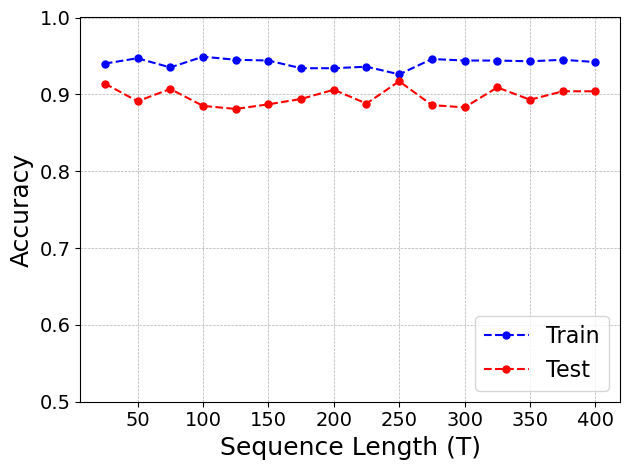

In [6]:
# Choose the index variable and the static variable for corresponding experiments
if experiment == 'length_independence':
    index_variable = T_values
    index_name = 'Sequence Length (T)'
    y_scale = 'linear'
    y_axis_label = 'Accuracy'
    static_variable = s_A_values[0]
    stat_var_name = 'sA'
else:
    raise ValueError("Experiment not found!")

# Choose a file name to save the results
plot_name = f"N_{N}_d_{d}_m_{m}_ep_{ep}_bs_{bs}_lr_{lr}_wd_{wd}_delta_{delta}_seed_{seed}"

# Plot the training and test accuracies on the same plot with color choice
plt.figure()
plt.plot(index_variable, list(train_results.values()), marker='.', linestyle='--', markersize=10, linewidth=1.5, color='blue', label='Train')
plt.plot(index_variable, list(test_results.values()), marker='.', linestyle='--', markersize=10, linewidth=1.5, color='red', label='Test')
# plt.plot(index_variable, np.abs(np.array(list(test_results.values())) - np.array(list(train_results.values()))), marker='.', linestyle='--', markersize=8, linewidth=1, color='green', label='Generalization Gap')
plt.xlabel(f'{index_name}', fontsize=18)
plt.ylabel(y_axis_label, fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title(f'{dataset.capitalize()} Dataset')
plt.yscale(y_scale)
plt.ylim(bottom = 0.5, top=1)
plt.margins(0.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='lower right', fontsize=16)
plt.tight_layout()
if save_results:
    plt.savefig(f'results/{experiment}/{dataset}/train_test_{stat_var_name}_{static_variable}_{plot_name}.pdf')
    plt.savefig(f'results/{experiment}/{dataset}/train_test_{stat_var_name}_{static_variable}_{plot_name}.png', dpi=300)